
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Before running this notebook, you must have already the numerically simulated waves NEARSHORE associated to the representative cases of synthetic simulated TCs (obtained with MaxDiss algorithm in notebook 06)

## HyCReeW: runup estimation of synthetic TC waves at 3 locations nearshore

The obtained runup will be used in the next step for obtaining the Daily Weather Types (KMA regression guided with runup data)


inputs required: 
  * Nearshore synthetic TC waves
  * TWL = 99th percentile of astronomical tide + IB

in this notebook:
  * HyCReWW runup estimation of historical data at 3 different locations


**HyCReWW** provides wave-driven run-up estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of run-up for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_reef$, $\beta_b$, $c_f$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), and seabed roughness ($c_f$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period. Beach crest elevation ($z_b$) was  <font color='red'>fixed at a height of 30 m </font> to focus on run-up as a proxy for coastal inundation.



<img src="fig_esquemas/d_hycreww.png">

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize




## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.

# reef characteristics
reef_cs = {
    'rslope': 0.0505,
    'bslope': 0.1667,
    'rwidth': 250,
    'cf': 0.0105,
}

var_lims, rbf_coeffs = db.Load_HYCREWW()
print(var_lims)
print()


# --------------------------------------
# Load nearshore TC waves for 3 points at sections North, East & South
WVS_N_10 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_synth_TCs/profiles_N_tcs_em_10.nc')
WVS_N_20 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_synth_TCs/profiles_N_tcs_em_20.nc')
WVS_N_20 = WVS_N_20.resample(date='10Min').interpolate('linear')
WVS_N = xr.concat([WVS_N_10,WVS_N_20], dim="case")

WVS_S_10 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_synth_TCs/profiles_S_tcs_em_10.nc')
WVS_S_20 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_synth_TCs/profiles_S_tcs_em_20.nc')
WVS_S_20 = WVS_S_20.resample(date='10Min').interpolate('linear')
WVS_S = xr.concat([WVS_S_10,WVS_S_20], dim="case")

WVS_E_10 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_synth_TCs/profiles_E_tcs_em_10.nc')
WVS_E_20 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_synth_TCs/profiles_E_tcs_em_20.nc')
WVS_E_20 = WVS_E_20.resample(date='10Min').interpolate('linear')
WVS_E = xr.concat([WVS_E_10,WVS_E_20], dim="case")

# N, S, E profiles. Select one profile representative from each section
pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)

WVS_N = WVS_N.sel(profile=pN)
WVS_S = WVS_S.sel(profile=pS)
WVS_E = WVS_E.sel(profile=pE)

WVS_N = WVS_N.drop('profile')
WVS_S = WVS_S.drop('profile')
WVS_E = WVS_E.drop('profile')

WVS_S = WVS_S.drop('tm')
WVS_E = WVS_E.drop('tm')

WVS_N = WVS_N.rename({'date':'time', 'case':'storm'})
WVS_S = WVS_S.rename({'date':'time', 'case':'storm'})
WVS_E = WVS_E.rename({'date':'time', 'case':'storm'})

print(WVS_N)    
print()
print(WVS_S)    
print()
print(WVS_E)    
print()


# --------------------------------------    
# Load astronomical tide from TG
# TIDE = db.Load_TIDE_sim_astro() # el percentil es el mismo que en el periodo historico y tarde menos en cargar
# AT = TIDE.astro - np.nanmean(TIDE.astro)
TIDE = db.Load_TIDE_hist_astro()
AT = TIDE.Predicted - np.nanmean(TIDE.Predicted)
print(AT)
print()


# --------------------------------------
# Sea Level Pressure for obtain pressure mean at the Site
SLP = db.Load_ESTELA_SLP()   # Sea Level Pressure from CFSR (Pa)
print(SLP)


# --------------------------------------
# Load parameters of selected synthetic TCs (for obtaining Storm Surge due to Inverse Barometer (IB))
TCs_r2_MDA_params = db.Load_TCs_r2_mda_params()
print(TCs_r2_MDA_params)
print()




{'level': array([-1.,  3.]), 'hs': array([1., 5.]), 'tp': array([ 3.4, 25.5]), 'rslope': array([0.05, 0.5 ]), 'bslope': array([0.05, 0.2 ]), 'rwidth': array([   0., 1500.]), 'cf': array([0.01, 0.1 ]), 'hs_lo2': [0.005, 0.05]}

<xarray.Dataset>
Dimensions:  (storm: 500, time: 2295)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-16T22:20:00
  * storm    (storm) int64 0 1 4 5 7 10 11 13 ... 484 486 490 491 497 498 499
Data variables:
    hs       (time, storm) float64 0.3538 0.0 1.353 0.0 ... nan nan nan nan
    tp       (time, storm) float64 2.903 3.383 4.751 3.23 ... nan nan nan nan
    dir      (time, storm) float64 309.1 339.8 292.2 353.7 ... nan nan nan nan

<xarray.Dataset>
Dimensions:  (storm: 500, time: 2295)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-16T22:20:00
  * storm    (storm) int64 0 1 4 5 7 10 11 13 ... 484 486 490 491 497 498 499
Data variables:
    hs       (time, storm) float64 0.1954 0.229 0.4591 0.2445 ... nan nan n

## Plot input data

Text(0.5, 1.0, 'Tide (m)')

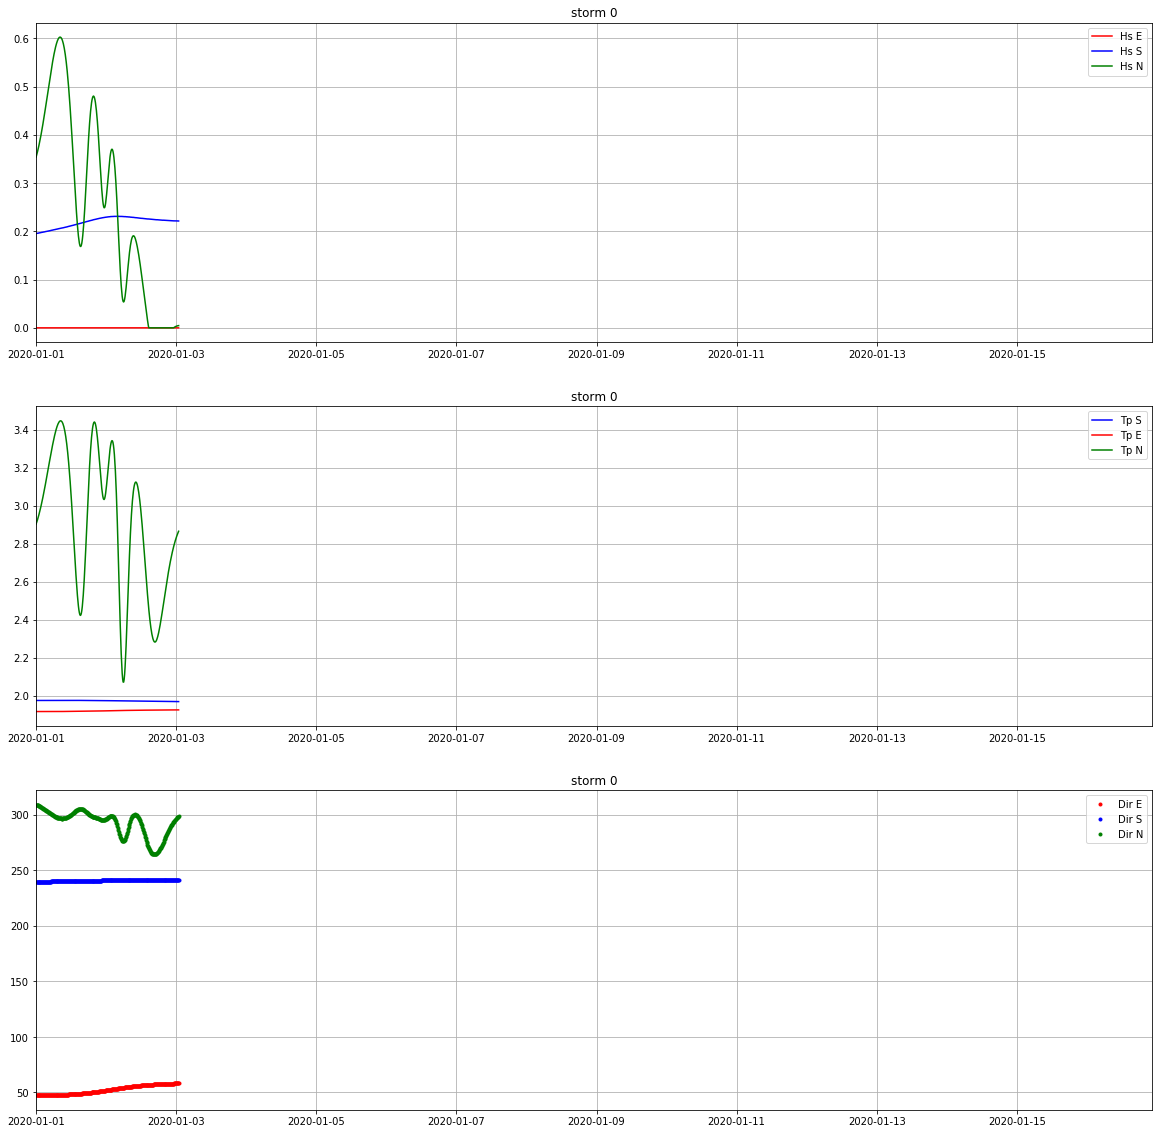

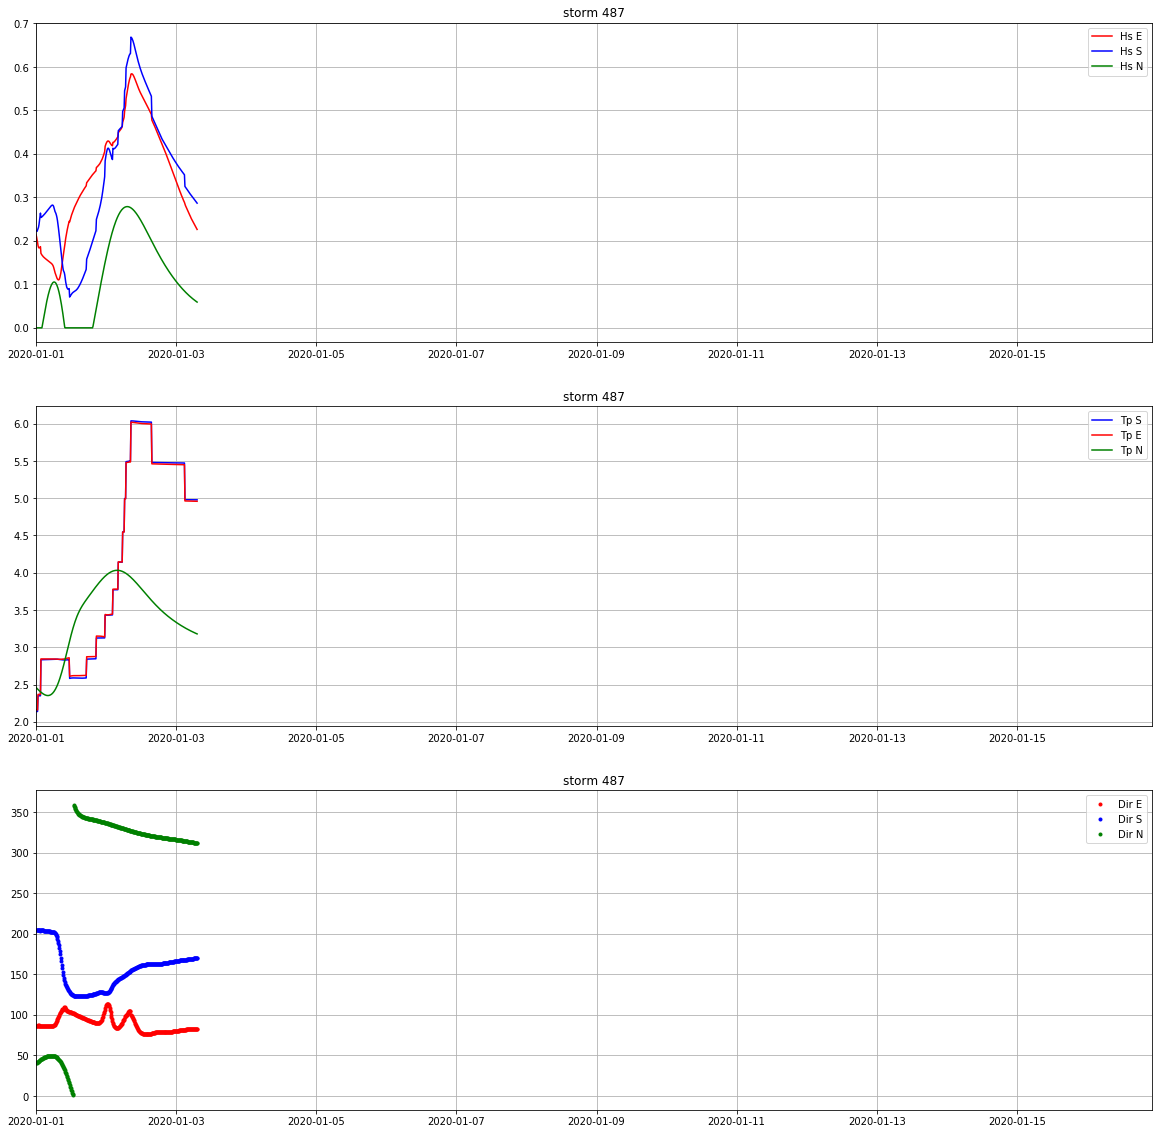

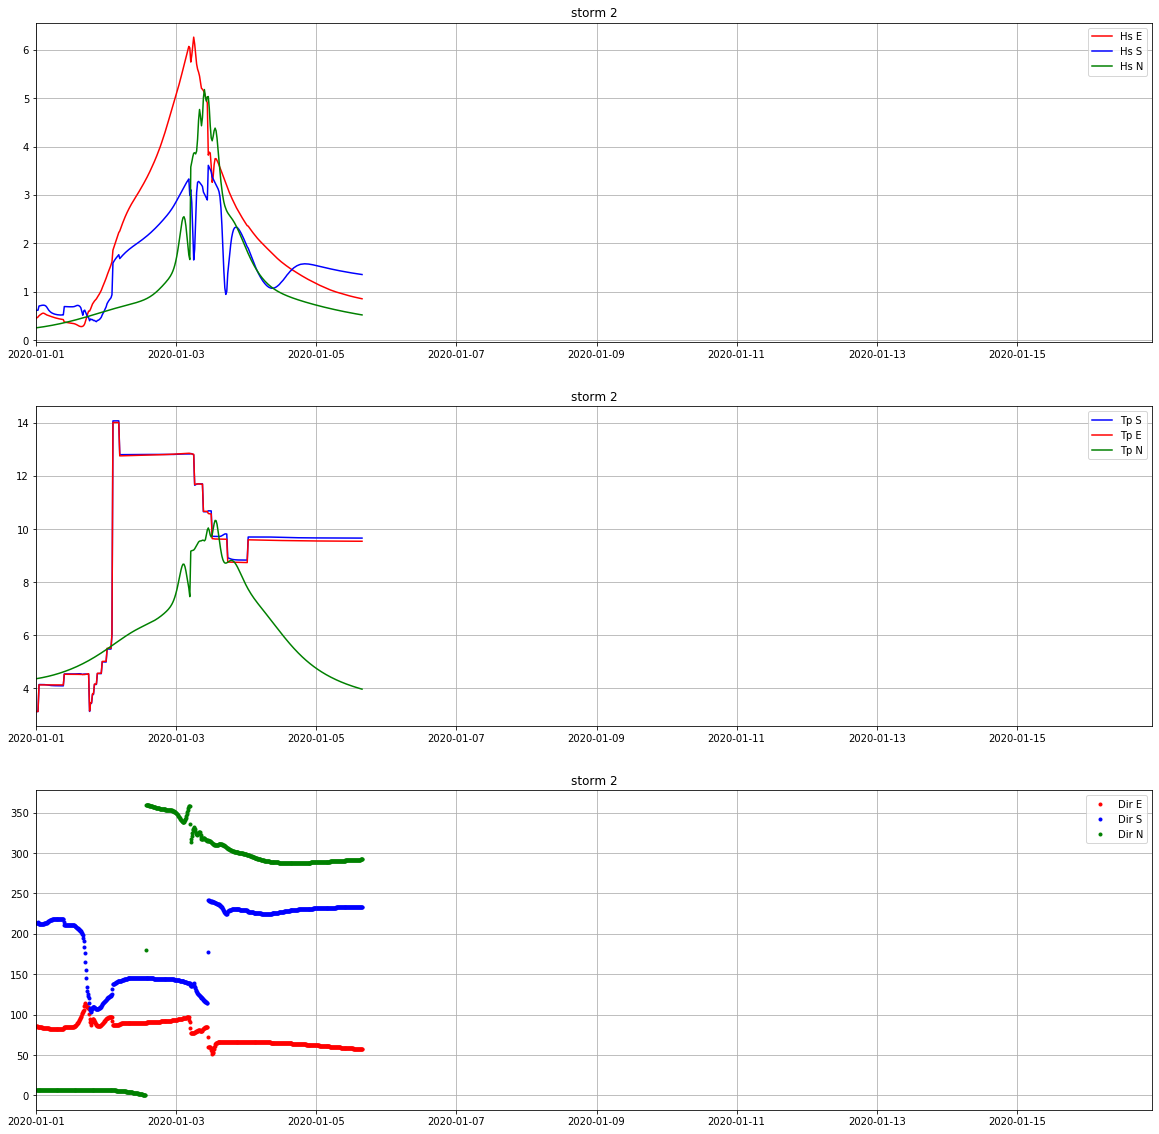

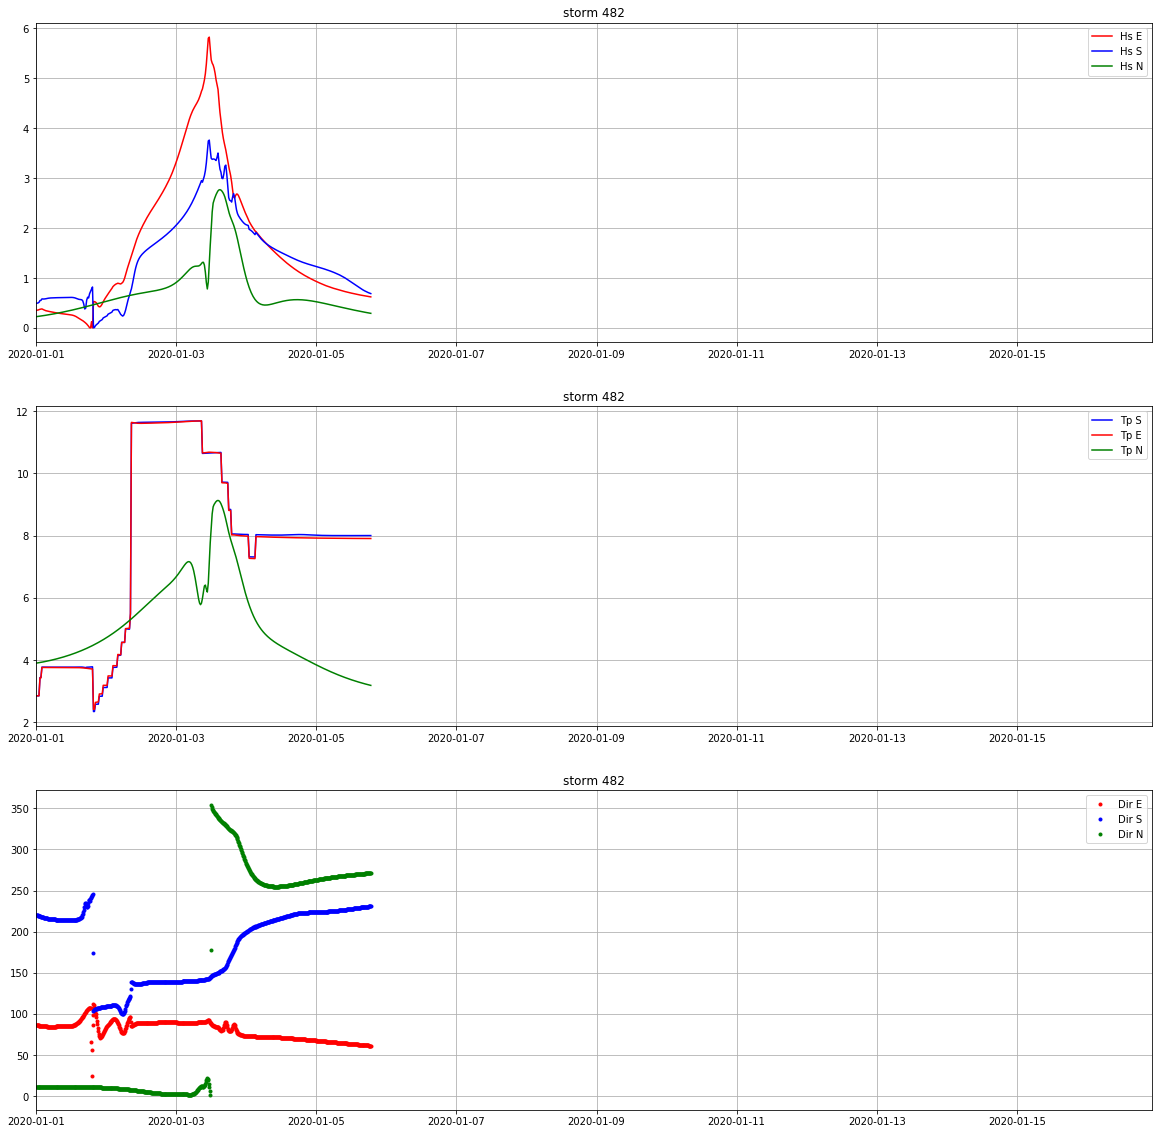

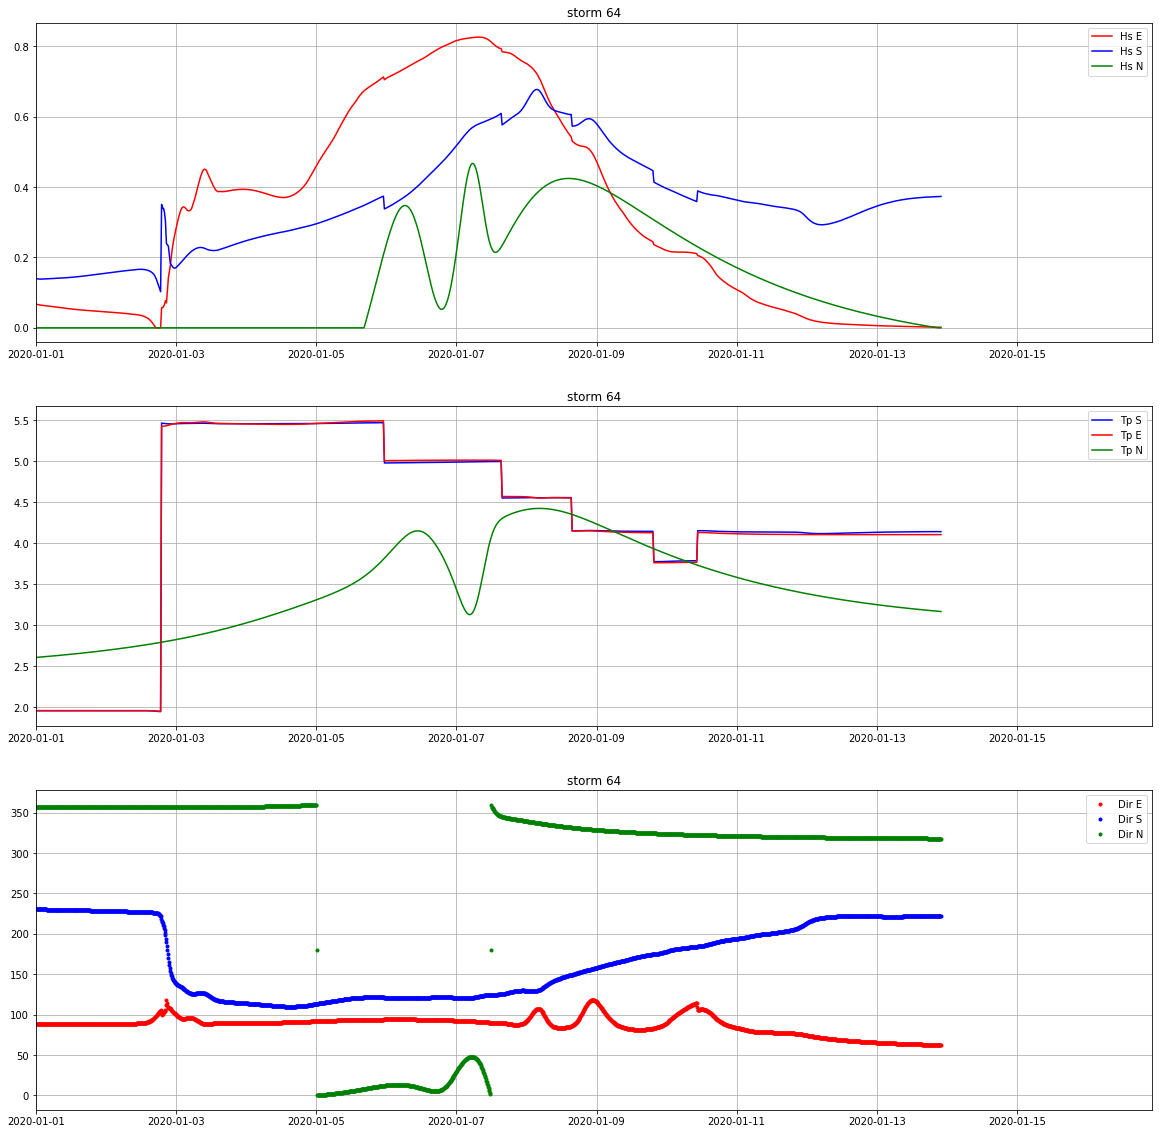

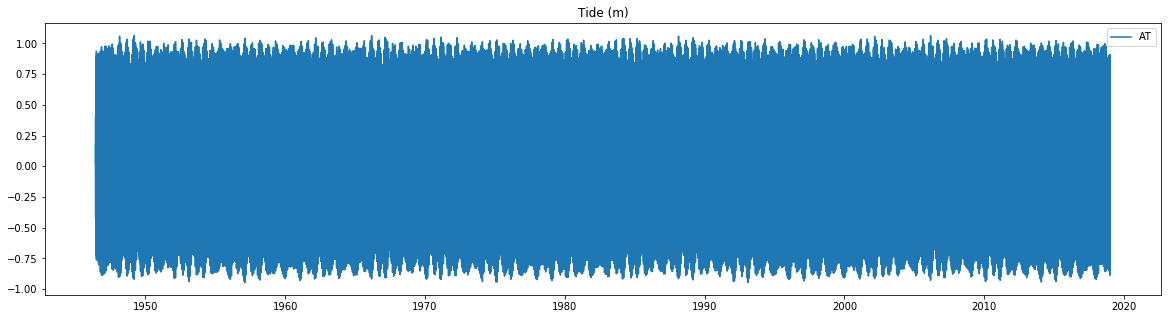

In [3]:
for c in [0,487, 2,482, 64]:  
    
    fig, axs = plt.subplots(3,1, figsize=(20,20))

    axs[0].plot(WVS_E.time, WVS_E.hs.sel(storm=c), color = 'r', label='Hs E')
    axs[0].plot(WVS_S.time, WVS_S.hs.sel(storm=c), color = 'b', label='Hs S')
    axs[0].plot(WVS_N.time, WVS_N.hs.sel(storm=c), color = 'g', label='Hs N')
    axs[0].legend()
    axs[0].set_xlim(WVS_E.time.values[0], WVS_E.time.values[-1])
    axs[0].set_title('storm ' + str(c))
    axs[0].grid()

    axs[1].plot(WVS_S.time, WVS_S.tp.sel(storm=c), color = 'b', label='Tp S')
    axs[1].plot(WVS_E.time, WVS_E.tp.sel(storm=c), color = 'r', label='Tp E')
    axs[1].plot(WVS_N.time, WVS_N.tp.sel(storm=c), color = 'g', label='Tp N')
    axs[1].legend()
    axs[1].set_xlim(WVS_E.time.values[0], WVS_E.time.values[-1])
    axs[1].set_title('storm ' + str(c))
    axs[1].grid()

    axs[2].plot(WVS_E.time, WVS_E.dir.sel(storm=c), '.r', label='Dir E')
    axs[2].plot(WVS_S.time, WVS_S.dir.sel(storm=c), '.b', label='Dir S')
    axs[2].plot(WVS_N.time, WVS_N.dir.sel(storm=c), '.g', label='Dir N')    
    axs[2].legend()
    axs[2].set_xlim(WVS_E.time.values[0], WVS_E.time.values[-1])
    axs[2].set_title('storm ' + str(c))
    axs[2].grid()


plt.figure(figsize=(20,5))
plt.plot(TIDE.time, TIDE.Predicted, label='AT')
plt.legend()
plt.title('Tide (m)')


## Obtain base level for Hycreww (99th percentile of AT & SS)

In [4]:
# --------------------------------------
# 99% of AT level
AT = AT - np.nanmean(AT)

AT = np.percentile(AT.values, 99)
print(AT)


# --------------------------------------
# Storm Surge from Inverse Barometer 

# Kwajalein: pnt_lon = 167.73, pnt_lat = 8.66
lonp = 168 # closest coordinates in SLP dataset
latp = 8

# select closest grid point to Site
SLP_p = SLP.sel(longitude = lonp, latitude = latp) 
SLPmean = np.mean(SLP_p.SLP*0.01) # (Pa to mb)
print(SLPmean)
print()

ss = TCs_r2_MDA_params.pressure_min - SLPmean
ss = -1*ss  # (Inverse Barometer: mb to cm)
ss = ss/100.0 # (cm to m)
ss = ss.rename('ss')
ss = ss.to_dataset()
print(ss) 
print()

level = AT + ss
level = level.rename({'ss':'level'})
print(level)

level = level.drop({'longitude', 'latitude'})

0.85196490774742
<xarray.DataArray 'SLP' ()>
array(1009.54487586)
Coordinates:
    longitude  float32 168.0
    latitude   float32 8.0

<xarray.Dataset>
Dimensions:    (storm: 500)
Coordinates:
  * storm      (storm) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
    longitude  float32 168.0
    latitude   float32 8.0
Data variables:
    ss         (storm) float64 -0.02465 0.14 1.024 ... 0.1631 0.5542 0.104

<xarray.Dataset>
Dimensions:    (storm: 500)
Coordinates:
  * storm      (storm) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
    longitude  float32 168.0
    latitude   float32 8.0
Data variables:
    level      (storm) float64 0.8273 0.992 1.876 0.8474 ... 1.015 1.406 0.956


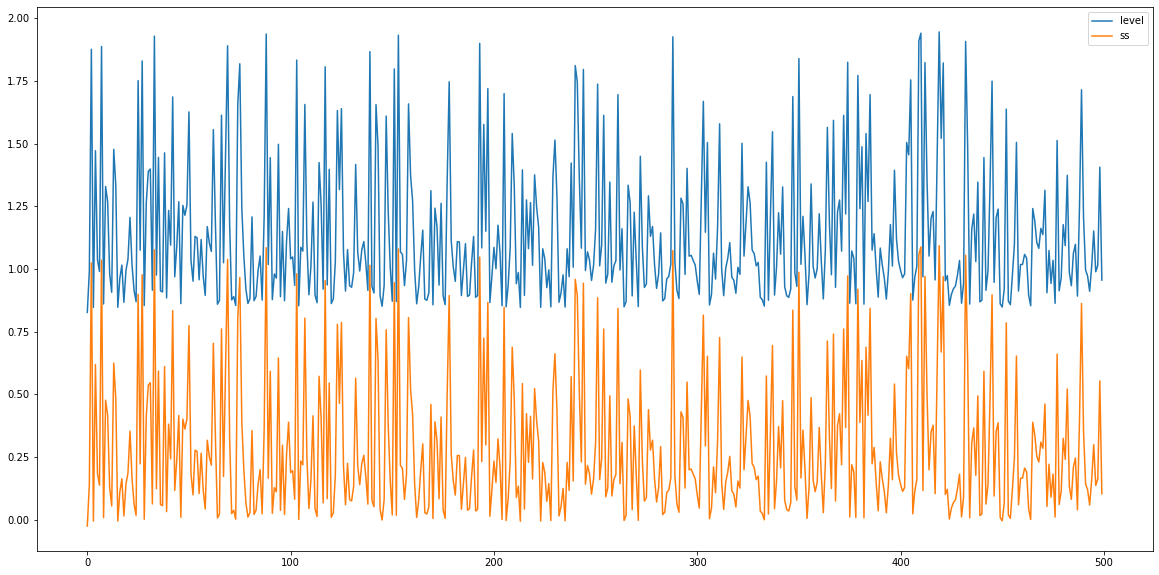

In [5]:
plt.figure(figsize=(20,10))
plt.plot(level.storm, level.level, label='level')
plt.plot(ss.storm, ss.ss, label= 'ss')
plt.legend()


## Hycreww RBF Interpolation

In [6]:
# hycreww interpolation 

def hycreww_runup(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (pandas.DataFrame with "rbf_vns" columns)
    
    '''
    
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'cf']
    
    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]
    
    
    # add reef characteristics
    for p in reef_cs.keys():
        dset[p] = reef_cs[p]

    # discard data outside limits
    for vn in var_lims.keys():
        dset = dset[(dset[vn] >= var_lims[vn][0]) &(dset[vn] <= var_lims[vn][1])]        

           
    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in.values, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)
    
    # RU Linear interpolation (hs, hs_lo -> runup)
    RU = []
    for c, (_, r) in enumerate(dset.iterrows()):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (r['hs'], r['hs_lo2']), method='linear')
        RU.append(vq)
    RU = np.array(RU)
    
    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['runup'] = dset_out['level'] + RU

    return dset_out


In [7]:
# Input data for hycreww

# add level
WVS_N = xr.merge([WVS_N, level])
WVS_S = xr.merge([WVS_S, level])
WVS_E = xr.merge([WVS_E, level])

# calc. hs_lo2
WVS_N['hs_lo2'] = WVS_N['hs']/(1.5613*WVS_N['tp']**2)            
WVS_S['hs_lo2'] = WVS_S['hs']/(1.5613*WVS_S['tp']**2)            
WVS_E['hs_lo2'] = WVS_E['hs']/(1.5613*WVS_E['tp']**2)           

print(WVS_N)
print(WVS_S)
print(WVS_E)

<xarray.Dataset>
Dimensions:  (storm: 500, time: 2295)
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-16T22:20:00
Data variables:
    hs       (time, storm) float64 0.3538 0.0 0.2533 0.0 ... nan nan nan nan
    tp       (time, storm) float64 2.903 3.383 4.366 2.987 ... nan nan nan nan
    dir      (time, storm) float64 309.1 339.8 6.425 337.3 ... nan nan nan nan
    level    (storm) float64 0.8273 0.992 1.876 0.8474 ... 1.015 1.406 0.956
    hs_lo2   (time, storm) float64 0.0269 0.0 0.008512 0.0 ... nan nan nan nan
<xarray.Dataset>
Dimensions:  (storm: 500, time: 2295)
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-16T22:20:00
Data variables:
    hs       (time, storm) float64 0.1954 0.229 0.6119 0.04943 ... nan nan nan
    tp       (time, storm) float64 1.975 2.363 3.135 1.772 .

### Adjust Hs, Tp & hs_lo2 to fit within Hycreww limits


In [8]:

for var in ['hs', 'tp', 'hs_lo2']:
    WVS_N['{variable}_orig'.format(variable=var)] = WVS_N[var].copy(deep=True)
    WVS_S['{variable}_orig'.format(variable=var)] = WVS_S[var].copy(deep=True)
    WVS_E['{variable}_orig'.format(variable=var)] = WVS_E[var].copy(deep=True)

    
for var in ['hs', 'tp', 'hs_lo2']:
    
    WVS_N[var] =  WVS_N[var].where(WVS_N[var]>=var_lims[var][0], var_lims[var][0] )
    WVS_N[var] =  WVS_N[var].where(WVS_N[var]<=var_lims[var][1], var_lims[var][1] )    
    
    WVS_S[var] =  WVS_S[var].where(WVS_S[var]>=var_lims[var][0], var_lims[var][0] )
    WVS_S[var] =  WVS_S[var].where(WVS_S[var]<=var_lims[var][1], var_lims[var][1] )    
    
    WVS_E[var] =  WVS_E[var].where(WVS_E[var]>=var_lims[var][0], var_lims[var][0] )
    WVS_E[var] =  WVS_E[var].where(WVS_E[var]<=var_lims[var][1], var_lims[var][1] )    
    
    

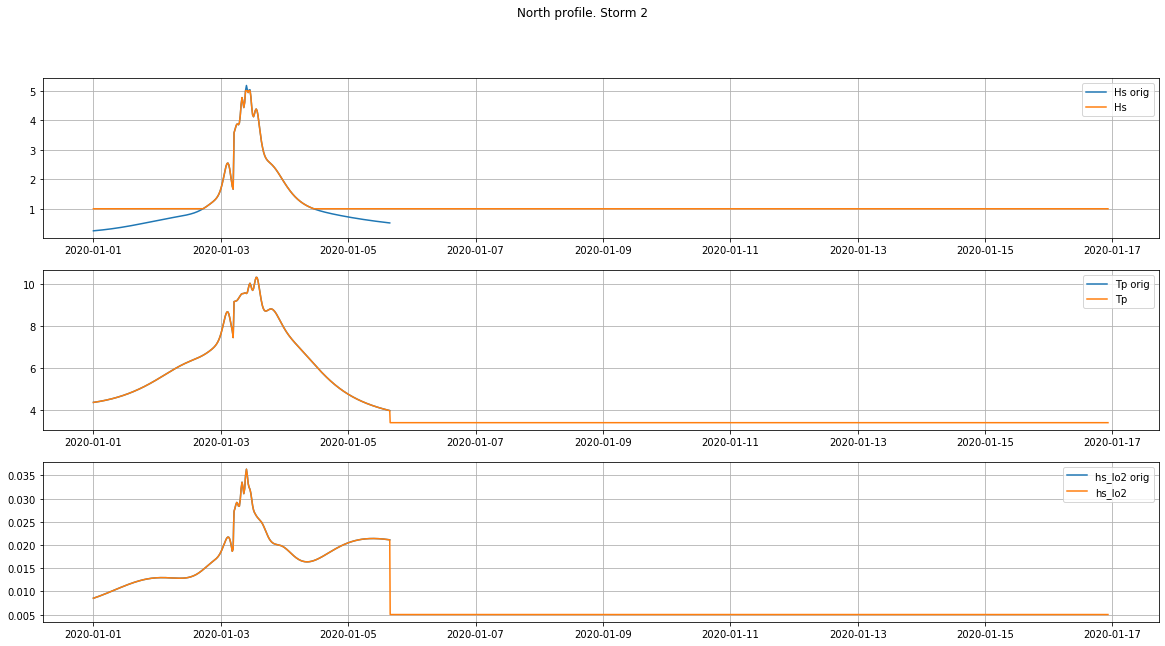

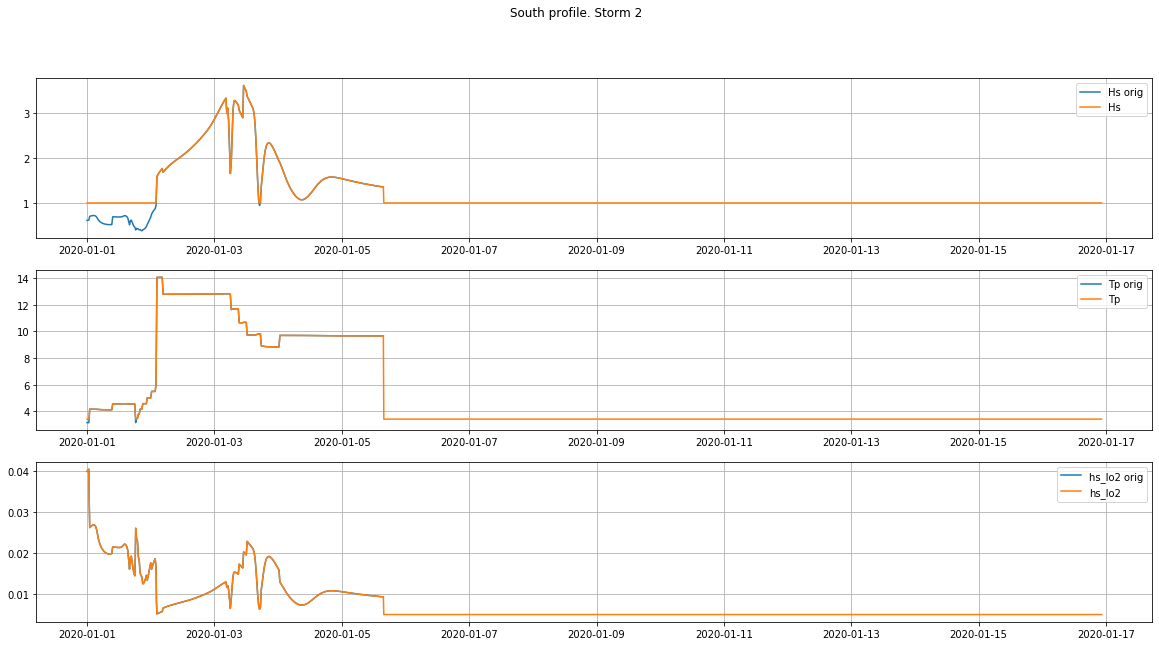

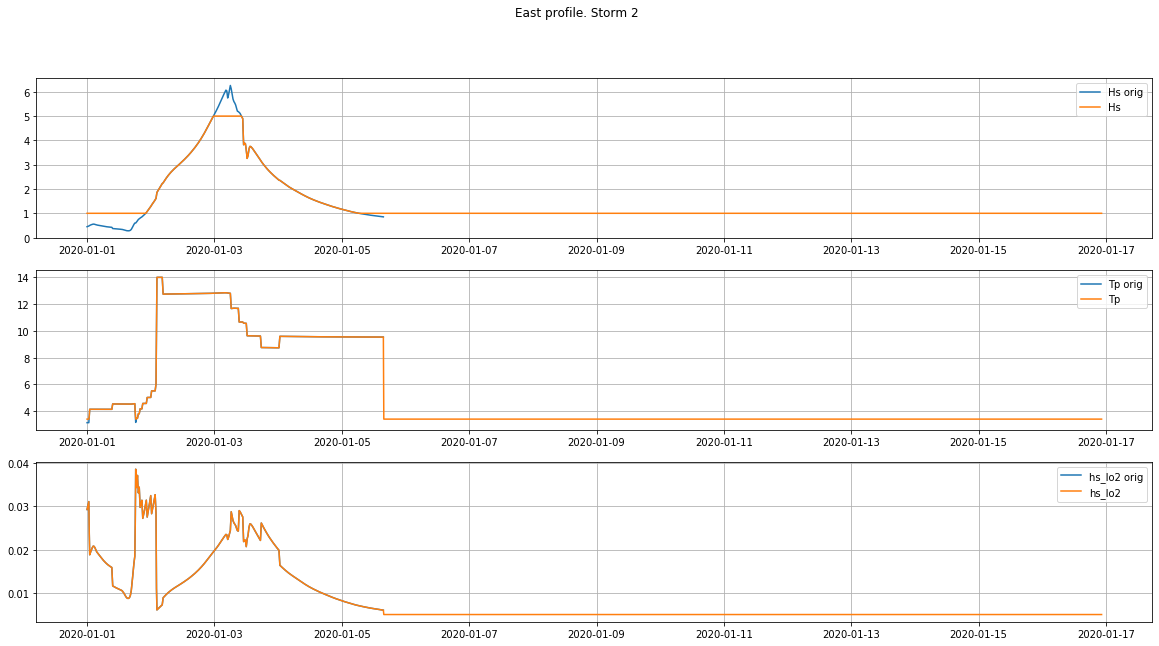

In [9]:
# plot Hs, Tp & hs_lo2 (original and adjusted for Hycreww)

titl = ['North', 'South','East']
WVS_sec = [WVS_N, WVS_S, WVS_E]

for c in [2]: #[0, 2, 64]:  
    
    for titl_s, WVS_s in zip(titl, WVS_sec):

        fig, axs = plt.subplots(3,1,figsize=(20,10))
        fig.suptitle(titl_s + ' profile. Storm ' + str(c))
        axs[0].plot(WVS_s.time, WVS_s.hs_orig.sel(storm=c), label='Hs orig')
        axs[0].plot(WVS_s.time, WVS_s.hs.sel(storm=c), label='Hs')
        axs[0].legend()
        axs[0].grid()

        axs[1].plot(WVS_s.time, WVS_s.tp_orig.sel(storm=c), label='Tp orig')
        axs[1].plot(WVS_s.time, WVS_s.tp.sel(storm=c), label='Tp')
        axs[1].legend()
        axs[1].grid()

        axs[2].plot(WVS_s.time, WVS_s.hs_lo2_orig.sel(storm=c), label='hs_lo2 orig')
        axs[2].plot(WVS_s.time, WVS_s.hs_lo2.sel(storm=c), label='hs_lo2')
        axs[2].legend()
        axs[2].grid()
    
    


### Calculate runup with hycreww

In [10]:
# Calculate runup at 3 locations

for s in WVS_N.storm.values:
    print(s)
    
    # NORTH
    WVS_N_s = WVS_N.sel(storm=s)
    WVS_N_s = WVS_N_s.drop_vars('storm')
    
    WVS_N_s = WVS_N_s.where(~np.isnan(WVS_N_s.dir), drop=True)    
    WVS_N_s = WVS_N_s[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()    

    out_WVS_N_s = hycreww_runup(var_lims, rbf_coeffs, WVS_N_s)
    out_WVS_N_s = out_WVS_N_s.to_xarray()
    
    out_WVS_N_s = out_WVS_N_s.assign_coords(storm=( s))
        
    if s==0:
        out_sim_N = out_WVS_N_s
    else:
        out_sim_N = xr.concat([out_sim_N, out_WVS_N_s], dim='storm')
    
    WVS_N_s = []
    out_WVS_N_s = []
    
    
    # SOUTH
    WVS_S_s = WVS_S.sel(storm=s)
    WVS_S_s = WVS_S_s.drop_vars('storm')
    
    WVS_S_s = WVS_S_s.where(~np.isnan(WVS_S_s.dir), drop=True)    
    WVS_S_s = WVS_S_s[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()    

    out_WVS_S_s = hycreww_runup(var_lims, rbf_coeffs, WVS_S_s)
    out_WVS_S_s = out_WVS_S_s.to_xarray()
    
    out_WVS_S_s = out_WVS_S_s.assign_coords(storm=( s))
        
    if s==0:
        out_sim_S = out_WVS_S_s
    else:
        out_sim_S = xr.concat([out_sim_S, out_WVS_S_s], dim='storm')
        
    WVS_S_s = []
    out_WVS_S_s = []
        
        
    # EAST
    WVS_E_s = WVS_E.sel(storm=s)
    WVS_E_s = WVS_E_s.drop_vars('storm')
    
    WVS_E_s = WVS_E_s.where(~np.isnan(WVS_E_s.dir), drop=True)    
    WVS_E_s = WVS_E_s[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()    

    out_WVS_E_s = hycreww_runup(var_lims, rbf_coeffs, WVS_E_s)
    out_WVS_E_s = out_WVS_E_s.to_xarray()
    
    out_WVS_E_s = out_WVS_E_s.assign_coords(storm=( s))
        
    if s==0:
        out_sim_E = out_WVS_E_s
    else:
        out_sim_E = xr.concat([out_sim_E, out_WVS_E_s], dim='storm')
    
    WVS_E_s = []
    out_WVS_E_s = []
    

out_sim_N = out_sim_N.transpose()
out_sim_S = out_sim_S.transpose()
out_sim_E = out_sim_E.transpose()

    
print(out_sim_N)
print(out_sim_S)
print(out_sim_S)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

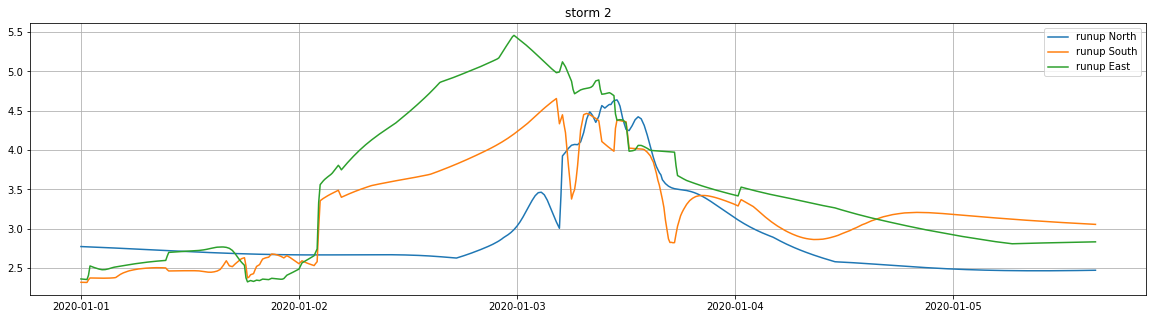

In [11]:
# plot Hycreww output

for s in [2]: #[0, 2, 64]: 
    
    plt.figure(figsize=(20,5))
    plt.plot(out_sim_N.time, out_sim_N.runup.sel(storm=s), label='runup North')    
    plt.plot(out_sim_S.time, out_sim_S.runup.sel(storm=s), label='runup South')
    plt.plot(out_sim_E.time, out_sim_E.runup.sel(storm=s), label='runup East')
    plt.legend()
    plt.grid()
    plt.title('storm ' + str(s))
    

### Re-scale runup according to original Hs

In [12]:

out_sim_N['runup_orig'] = out_sim_N['runup'].copy(deep=True)
out_sim_S['runup_orig'] = out_sim_S['runup'].copy(deep=True)
out_sim_E['runup_orig'] = out_sim_E['runup'].copy(deep=True)


# para borrar ---------------------------------------------------------
#WVS_N = WVS_N.sel(storm=[0,2,64], time=out_sim_N.time)
#WVS_S = WVS_S.sel(storm=[0,2,64], time=out_sim_S.time)
#WVS_E = WVS_E.sel(storm=[0,2,64], time=out_sim_E.time)



# re-adjust by Hs min lim. (For waves lower than 1m, multiply runup by the original waves value)
    
out_sim_N['runup_orig'] = out_sim_N['runup_orig'].where(WVS_N['hs_orig']>=var_lims['hs'][0], out_sim_N['runup_orig']*WVS_N['hs_orig'])
out_sim_S['runup_orig'] = out_sim_S['runup_orig'].where(WVS_S['hs_orig']>=var_lims['hs'][0], out_sim_S['runup_orig']*WVS_S['hs_orig'])
out_sim_E['runup_orig'] = out_sim_E['runup_orig'].where(WVS_E['hs_orig']>=var_lims['hs'][0], out_sim_E['runup_orig']*WVS_E['hs_orig'])


# re-adjust by Hs max lim

out_sim_N['runup_orig'] = out_sim_N['runup_orig'].where(WVS_N['hs_orig']<=var_lims['hs'][1], out_sim_N['runup_orig']*(1+(WVS_N['hs_orig']-var_lims['hs'][1])/np.nanmax(WVS_N['hs_orig'].values)))
out_sim_S['runup_orig'] = out_sim_S['runup_orig'].where(WVS_S['hs_orig']<=var_lims['hs'][1], out_sim_S['runup_orig']*(1+(WVS_S['hs_orig']-var_lims['hs'][1])/np.nanmax(WVS_S['hs_orig'].values)))
out_sim_E['runup_orig'] = out_sim_E['runup_orig'].where(WVS_E['hs_orig']<=var_lims['hs'][1], out_sim_E['runup_orig']*(1+(WVS_E['hs_orig']-var_lims['hs'][1])/np.nanmax(WVS_E['hs_orig'].values)))




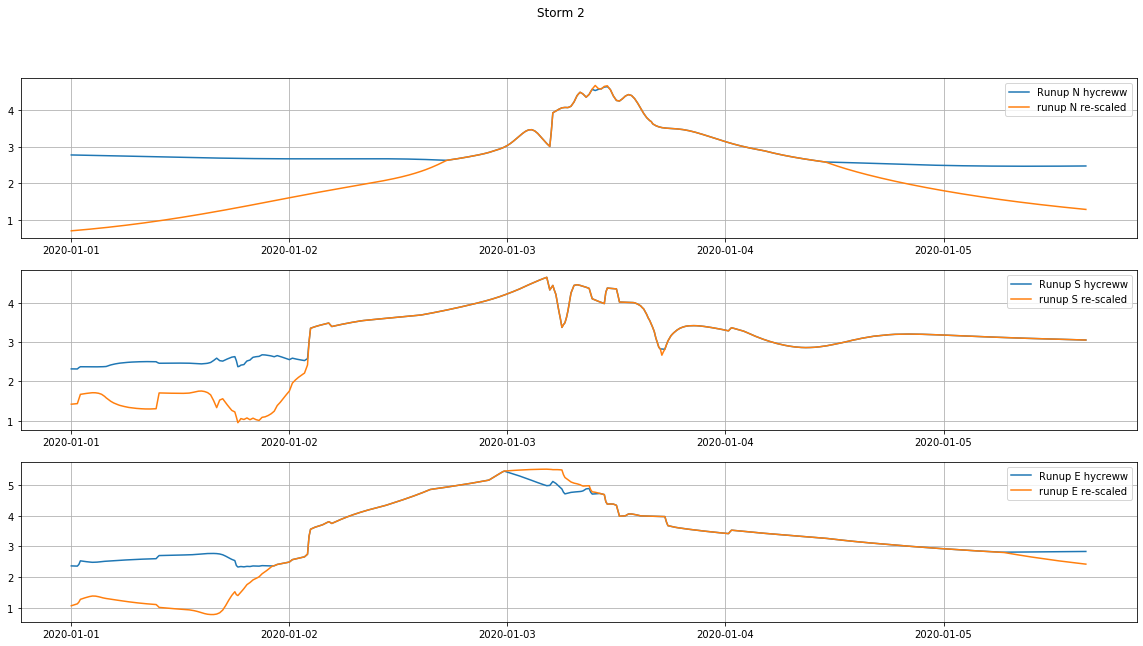

In [13]:
for s in [2]:#[0, 2, 64]: 
    
    fig, axs = plt.subplots(3,1, figsize=(20,10))
    fig.suptitle('Storm ' + str(s))
    
    axs[0].plot(out_sim_N.time, out_sim_N.runup.sel(storm=s), label='Runup N hycreww')
    axs[0].plot(out_sim_N.time, out_sim_N.runup_orig.sel(storm=s), label='runup N re-scaled')
    axs[0].legend()
    axs[0].grid()
    

    axs[1].plot(out_sim_S.time, out_sim_S.runup.sel(storm=s), label='Runup S hycreww')
    axs[1].plot(out_sim_S.time, out_sim_S.runup_orig.sel(storm=s), label='runup S re-scaled')
    axs[1].legend()
    axs[1].grid()


    axs[2].plot(out_sim_E.time, out_sim_E.runup.sel(storm=s), label='Runup E hycreww')
    axs[2].plot(out_sim_E.time, out_sim_E.runup_orig.sel(storm=s), label='runup E re-scaled')
    axs[2].legend()
    axs[2].grid()

In [14]:
# Save

# replace adjusted variables
out_sim_N['hs'].values = WVS_N['hs_orig'].values
out_sim_S['hs'].values = WVS_S['hs_orig'].values
out_sim_E['hs'].values = WVS_E['hs_orig'].values

out_sim_N['tp'].values = WVS_N['tp_orig'].values
out_sim_S['tp'].values = WVS_S['tp_orig'].values
out_sim_E['tp'].values = WVS_E['tp_orig'].values

out_sim_N['hs_lo2'].values = WVS_N['hs_lo2_orig'].values
out_sim_S['hs_lo2'].values = WVS_S['hs_lo2_orig'].values
out_sim_E['hs_lo2'].values = WVS_E['hs_lo2_orig'].values

# rename vars
out_sim_N = out_sim_N.drop_vars(['runup'])
out_sim_S = out_sim_S.drop_vars(['runup'])
out_sim_E = out_sim_E.drop_vars(['runup'])

out_sim_N = out_sim_N.rename_vars({"runup_orig": "runup"})  
out_sim_S = out_sim_S.rename_vars({"runup_orig": "runup"})  
out_sim_E = out_sim_E.rename_vars({"runup_orig": "runup"})  

# Save
out_sim_N.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/sim_TCs_runup_N.nc')
out_sim_S.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/sim_TCs_runup_S.nc')
out_sim_E.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/sim_TCs_runup_E.nc')


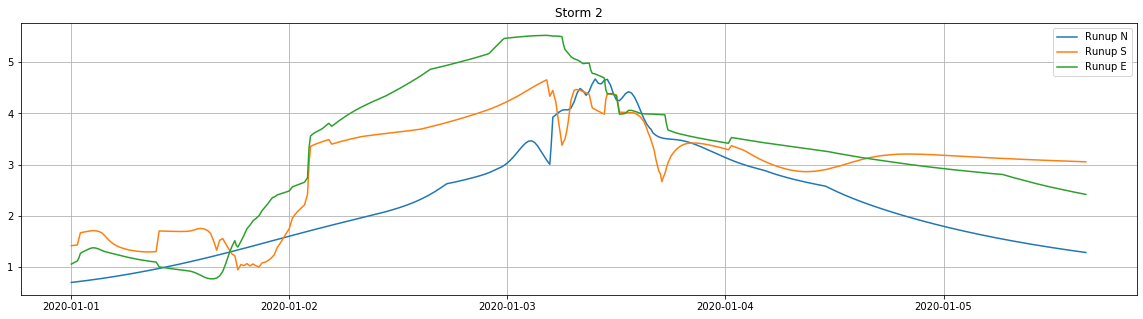

In [15]:
# plot runup

for s in [2]: #[0, 2, 64]: 
    
    plt.figure(figsize=(20,5))

    plt.plot(out_sim_N.time, out_sim_N.runup.sel(storm=s), label='Runup N')
    plt.plot(out_sim_S.time, out_sim_S.runup.sel(storm=s), label='Runup S')
    plt.plot(out_sim_E.time, out_sim_E.runup.sel(storm=s), label='Runup E')
    plt.legend()
    plt.grid()
    plt.title('Storm ' + str(s))

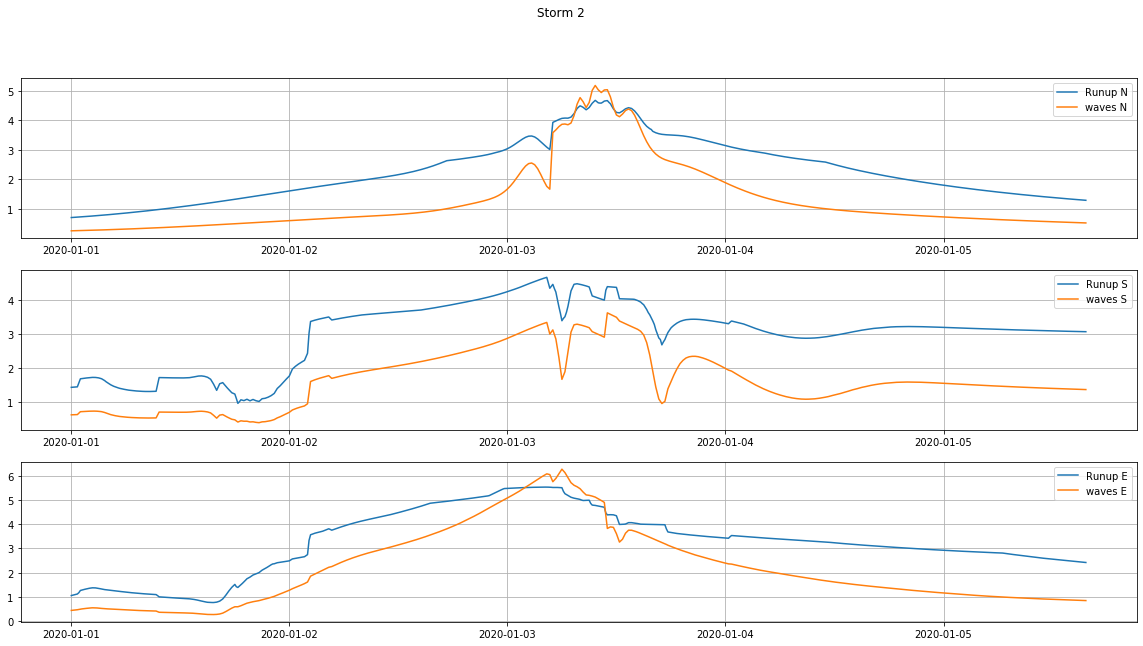

In [16]:
# plot comparison between waves and runup

for s in [2]:# [0, 2, 64]: 
    
    fig, axs = plt.subplots(3,1, figsize=(20,10))
    fig.suptitle('Storm ' + str(s))
    
    axs[0].plot(out_sim_N.time, out_sim_N.runup.sel(storm=s), label='Runup N')
    axs[0].plot(out_sim_N.time, out_sim_N.hs.sel(storm=s), label='waves N')
    axs[0].legend()
    axs[0].grid()
    
    axs[1].plot(out_sim_S.time, out_sim_S.runup.sel(storm=s), label='Runup S')
    axs[1].plot(out_sim_S.time, out_sim_S.hs.sel(storm=s), label='waves S')
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(out_sim_E.time, out_sim_E.runup.sel(storm=s), label='Runup E')
    axs[2].plot(out_sim_E.time, out_sim_E.hs.sel(storm=s), label='waves E')
    axs[2].legend()
    axs[2].grid()